# [Target Network] Main Training

In [1]:
import pandas as pd
import numpy as np
import itertools
from tqdm.notebook import tqdm
import pickle

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from collections import defaultdict
import warnings
from sklearn.preprocessing import LabelEncoder
import random
from datetime import datetime
import pytz
import line_profiler

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Fix Random Seeds

In [2]:
def same_seeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
  np.random.seed(seed)  
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

same_seeds(0)

## Prepare Data

In [3]:
CONTEXT_REPS = pd.read_pickle('../../data/w_final_context.pkl')
STREAM_ITEM_DICT = pd.read_pickle('../../data/stream_item_dict.pkl')
BERT_BY_IDX_DF = pd.read_pickle('../../data/bert_by_idx_pca.pkl')
BOUGHT_DICT = pd.read_pickle('../../data/bought_dict.pkl')
USER_ALL_STREAM_INIT = CONTEXT_REPS.describe().loc['50%']

In [4]:
CONTEXT_REPS.shape, len(STREAM_ITEM_DICT), BERT_BY_IDX_DF.shape, len(BOUGHT_DICT)

((1397141, 219), 7701, (162189, 160), 79207)

In [5]:
USER_LIST = CONTEXT_REPS.index.get_level_values('asid').tolist()

In [6]:
LB_ITEMS = ['item_id'] + [f'i{x}' for x in range(160)]
INPUT_DF_COL__USR = CONTEXT_REPS.columns.to_list()
INPUT_DF_COL = INPUT_DF_COL__USR + LB_ITEMS

'''
METHOD FOR BOTH EXP_REPLAY & DQN
Convert state format to model input format
'''
def get_input_tensor(input_state, current_stream, with_tensor=False):
  # Get item feats
  # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})

  # Fill in other context
  stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
  
  # Merge with items
  stream_item_feat = stream_item_feat.merge(item_feat, left_index=True, right_index=True).astype('float32')
  
  # Convert to tensor
  if with_tensor: 
    stream_item_feat_tensor = df_to_tensor(stream_item_feat)
    return stream_item_feat_tensor, stream_item_feat
  else:
    return stream_item_feat

In [7]:
'''
METHOD FOR BOTH EXP_REPLAY & DQN

Generate series: whether elements in A existed in list B
A, B: List
return: pd.Series
example:
  A: [1, 2, 4, 5]
  B: [1, 2, 3, 4, 5, 6, 7]
  return: Series([1, 1, 0, 1, 1, 0, 0], index=[1, 2, 3, 4, 5, 6, 7])
'''
def gen_exist_series(A, B):
  return [int(item in A) for item in B]

In [8]:
def df_to_tensor(input_df):
  return torch.tensor(input_df.values).to(DEVICE).float()

---

## Replay

In [34]:
class ReplayBuffer:
  def __init__(self, max_memory=100000, discount=.9, model_output_shape=1):
    """
    Setup
    max_memory: the maximum number of experiences we want to store
    memory: a list of experiences
    discount: the discount factor for future experience
    In the memory the information whether the game ended at the state is stored seperately in a nested array
    [...
    [experience, game_over]
    [experience, game_over]
    ...]
    """
    self.max_memory = max_memory
    self.memory = list()
    self.discount = discount
    self.model_output_shape = model_output_shape

  def remember(self, states, game_over):
    # Save a state to memory
    self.memory.append([states, game_over])
    # We don't want to store infinite memories, so if we have too many, we just delete the oldest one
    if len(self.memory) > self.max_memory:
      del self.memory[0]

  def get_batch(self, eval_net, target_net, batch_size=10):
    # How many experiences do we have?
    len_memory = len(self.memory)

    # Calculate the number of actions that can possibly be taken in the game.
    # Actions: 0 = not recommend, 1 = recommend
    num_actions = self.model_output_shape

    # Dimensions of our observed states, ie, the input to our model.
    # Memory:  [
    #   [ [ [stream, next_stream], [...state], action, reward, next_state_idx], game_over],
    #   [ [ [stream, next_stream], [...state], action, reward, nexr_state_idx], game_over],
    #   ...
    # ]
    env_dim = len(INPUT_DF_COL)

    inputs = pd.DataFrame()
    targets = torch.tensor([], dtype=torch.float32).to(DEVICE)
    
    
    # We draw states to learn from randomly
    for i, idx in enumerate(np.random.randint(0, len_memory, size=min(len_memory, batch_size))):  
      # Here we load one transition <s, a, r, s'> from memory
      streams, state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
      current_stream, next_stream = streams
      game_over = self.memory[idx][1]

      '''
      修改倒入 state 的方式 input = (state - item) + item_feat
      拆掉 model_predict 成 function
      
      here should be state_t * all_items
      '''
      state_tensor, state_t = get_input_tensor(state_t, current_stream, with_tensor=True)
      # puts state into input
      inputs = pd.concat([inputs, state_t], axis=0)
      
      # use target_net to predict target for eval_net to learn
      # current_target = target_net(state_tensor).detach().view(len(reward_t), 1)

      # selected_ids = np.where(action_t > 0)[0]
      reward_t = df_to_tensor(reward_t).view(len(reward_t), 1)
      
      
      '''
      每個 actions 都會被 predict 一個成績/reward
      '''
      # if the game ended, the reward is the final reward
      if game_over:  # if game_over is True
        current_target = reward_t
      else:
        state_tp1, _ = get_input_tensor(state_tp1, next_stream, with_tensor=True)
        if target_net == None:
          Q_sa = torch.max(eval_net(state_tp1))
        else:
          Q_sa = torch.max(target_net(state_tp1).detach())
        
        # r + gamma * max Q(s',a')
        # current_target = reward_t + self.discount * Q_sa
        current_target = reward_t.add(Q_sa, alpha=self.discount)

      targets = torch.cat((targets, current_target), 0)
    return inputs, targets

## Epsilon

In [30]:
from abc import ABC, abstractmethod
import math

class Epsilon(ABC):
  @abstractmethod
  def clear(self):
    pass
  
  @abstractmethod
  def get_epsilon(self, key):
    pass
  
  @abstractmethod
  def update_at_step(self, key, data, delta):
    pass
  
  @abstractmethod
  def update_at_epoch(self, data):
    pass
  
  # @abstractmethod
  # def update_at_epsisode():
  #   pass


class Decay(Epsilon):
  # Ref: Decay(0.5, 0.85)
  '''
  Epsilon Decay EE method with update/decay at epoch
  '''
  def __init__(self, initial, epoch_decay, step_decay=1.0):
    self.initial = initial
    self.epoch_decay, self.step_decay = epoch_decay, step_decay
    self.epsilon = self.initial
    
  def clear(self):
    self.epsilon = self.initial # should be 4 for origin setting
    
  def get_epsilon(self, key):
    return self.epsilon
  
  def update_at_step(self, key, data, delta):
    # origin setting
    pass
    # exponentially
    # self.epsilon *= self.step_decay
    
  def update_at_epoch(self, data):
    # origin settings
    epoch = data
    self.epsilon = 4 / ((epoch + 1) ** (1 / 2))
    # exponentially
    # self.epsilon *= self.epoch_decay


class VDBE(Epsilon):
  # VDBE(0.5, 0.01)
  def __init__(self, initial, sigma):
    self.initial = initial
    self.sigma = sigma

  def clear(self):
    self.epsilon = defaultdict(lambda: self.initial)

  def get_epsilon(self, key):
    return self.epsilon[key]
  
  def update_at_step(self, key, data, delta):
    td_error = data
    coeff = math.exp(-abs(td_error) / self.sigma)
    f = (1.0 - coeff) / (1.0 + coeff)
    self.epsilon[key] = delta * f + (1.0 - delta) * self.epsilon[key]
  
  def update_at_epoch(self, data):
    pass

## DQN

In [22]:
class DQN(object):
  def __init__(self, target_net, exp_replay, epsilon, num_episode, epochs, batch_size, lr, switch_param_threshold, single_reward):
    self.eval_net = Net()
    self.target_net = Net() if target_net else None
    self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
    self.loss_fn = nn.MSELoss()
    self.exp_replay = exp_replay
    self.epsilon = epsilon
    self.num_episode = num_episode
    self.epochs = epochs
    self.batch_size = batch_size
    self.switch_param_threshold = switch_param_threshold
    self.single_reward = single_reward
    self.user_all_stream_init = USER_ALL_STREAM_INIT
    self.hist = []
    self.c_hist = []
    self.rec_list = []
    self.ep_score_list = []
    self.learn_step_counter = 0

  # Environment Methods
  def __episodes(self):
    # return USER_LIST[:self.num_episode]
    return np.random.choice(USER_LIST, self.num_episode, replace=False)
  
  def __user_episode_context(self):
    self.user_all_streams = CONTEXT_REPS.xs(self.asid, level="asid")
    self.stream_list = self.user_all_streams.index
    self.final_stream = max(self.stream_list)
  
  def __full_state(self, i):
    '''
    retrieve full state -> should be exported to pickle
    '''
    if (i - 1) == -1:
      user_part = self.user_all_stream_init.copy()
      user_part.name = self.stream_list[i]
    else:
      user_part = self.user_all_streams.loc[self.stream_list[(i - 1)]]
    return user_part

  def reward(self):
    '''
    Comparison function for reward, 考慮「所有」歷史購買紀錄
    '''
    real_bought_ids = BOUGHT_DICT[self.asid]
    real_bought_ids_series = gen_exist_series(real_bought_ids, self.stream_items)
    
    reward_list = [a & b for a, b in zip(real_bought_ids_series, self.action_ids)]
    # Reward Count 
    self.rec_cnt += 1
    if sum(reward_list) > 0:
      self.c_win_cnt += 1
      self.win_cnt += 1
      self.ep_score += sum(reward_list)
    # return list(map(lambda x: x * sum(reward_list), reward_list))
    if self.single_reward:
      return pd.Series(reward_list, index=self.stream_items)
    else:
      return pd.Series(list(map(lambda x: x * sum(reward_list), reward_list)), index=self.stream_items)

  # Agent Methods
  def __choose_actions(self):
    if np.random.rand() <= self.epsilon.get_epsilon(self.asid):
    # if len(self.exp_replay.memory) < 1:
      # Explore by randomly select 10/n items from candidate_items
      # Get all items from the stream
      self.explore += 1
      selected_actions = random.sample(self.stream_items, 10) if len(self.stream_items) > 10 else self.stream_items
    else:
      # Exploit by choosing action from the model's prediction
      self.exploit += 1
      selected_actions = self.__agent_predict()
    x = pd.Series(0, index=self.stream_items)
    x.loc[selected_actions] = 1
    return x
    
  def q_value(self): 
    if type(self.epsilon) == Decay: return 0

    predicts = self.eval_net(self.full_input).flatten()    
    actions_idx = np.where(self.action_ids.values == 1)[0]
    q_val = predicts[actions_idx].mean()
    return q_val

  def __agent_predict(self):
    predicts = self.eval_net(self.full_input).flatten()
    if len(predicts) > 10:
      top10_idx = torch.topk(predicts, 10).indices.cpu()
      actions = self.candidate_actions.iloc[top10_idx]['item_id'].values
    else:
      actions = self.candidate_actions['item_id'].values
    return actions

  def __train_agent_batch(self, inputs, targets):
    self.optimizer.zero_grad()
    outputs = self.eval_net(inputs)
    loss = self.loss_fn(outputs, targets)
    # Add CL Regularization Term
    loss.backward()
    self.optimizer.step()
    return loss.item()

  # MAIN TRAIN
  def train(self):
    self.eval_net.to(DEVICE)
    if self.target_net:
      self.target_net.to(DEVICE)
    self.c_win_cnt = 0
    self.eval_net.train(True)
    self.epsilon.clear()

    for e in self.epochs:
      self.rec_cnt = 0
      self.win_cnt = 0
      self.loss = 0.
      self.ep_score = 0
      self.explore = 0
      self.exploit = 0

      print(f'Epoch {e} started.   Time: {datetime.now(pytz.timezone("Asia/Taipei")).strftime("%H:%M:%S")}')
      # ------------------- Episode (User) -------------------------------
      for asid in tqdm(self.__episodes()):
        self.asid = asid
        self.__user_episode_context()

        # ----------------- Runs (User x All_Stream) ---------------------
        for i, stream in enumerate(self.stream_list):
          game_over = stream == self.final_stream
          self.current_stream = stream
          self.current_state = self.__full_state(i)
          self.stream_items = STREAM_ITEM_DICT[self.current_stream]
          self.full_input, self.candidate_actions = get_input_tensor(self.current_state, self.current_stream, with_tensor=True)

          # --------------- Explore/Exploit Section ----------------------
          self.action_ids = self.__choose_actions()

          # --------------- Get next state & info to store ---------------
          reward = self.reward()
          next_state = self.__full_state(i+1) if not game_over else []
          next_stream = 0 if (i + 1) == len(self.stream_list) else self.stream_list[i + 1]
          self.exp_replay.remember([[stream, next_stream], self.current_state, self.action_ids, reward, next_state], game_over)
          self.learn_step_counter += 1
          if self.target_net and (self.learn_step_counter % self.switch_param_threshold == 0):
            self.target_net.load_state_dict(self.eval_net.state_dict())


          # --------------- Load batch of experiences --------------------
          inputs, targets = self.exp_replay.get_batch(self.eval_net, self.target_net, batch_size=self.batch_size)
          inputs = df_to_tensor(inputs)
          # store pre-training value for td_error
          old_Q = self.q_value()
          batch_loss = self.__train_agent_batch(inputs, targets)
          # store post-training value for td_error
          new_Q = self.q_value()
          self.loss += batch_loss

          # --------------- Update with TD error -------------------------
          self.epsilon.update_at_step(self.asid, (new_Q - old_Q), len(self.stream_items))

      # Track win history to later check if our model is improving at the game over time.
      self.hist.append(self.win_cnt)
      self.c_hist.append(self.c_win_cnt)
      self.rec_list.append(self.rec_cnt)
      self.ep_score_list.append(self.ep_score)

      print(f'Epoch: {e}/{len(self.epochs)} | Loss {self.loss} | Epoch Hit Rate {self.win_cnt/self.rec_cnt} | \
              Cumulative Hit Rate {self.c_win_cnt/sum(self.rec_list)} | Explore {self.explore} | Exploit {self.exploit} | \
              Score {self.ep_score}')

## Main Method

In [13]:
pd.set_option('mode.chained_assignment', None)

# parameters
MAX_MEMORY = 1000  # Maximum number of experiences we are storing
BATCH_SIZE = 2  # Number of experiences we use for training per batch
EPOCH = range(100)
TOTAL_ACTIONS = 1 # probability of ordering
NUM_EPISODE = 100
HIDDEN_SIZE = 512
LR = 1.0e-4
SWITCH_PARAM_THRESHOLD = 100

warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(380, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 1)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.tanh(x)
    x = self.fc5(x)
    return x

## Exp: Reward Setting

In [ ]:
'''
EPS_baseline_rsingle_x

- VDBE(0.5, 0.01)
- Decay(0.5, 0.85)
'''

exp_replay = ReplayBuffer(max_memory=MAX_MEMORY)
epsilon = Decay(0.5, 0.85)
dqn = DQN(False, exp_replay, epsilon, NUM_EPISODE, EPOCH, BATCH_SIZE, LR, SWITCH_PARAM_THRESHOLD, single_reward=True)
dqn.train()

Epoch 0 started.   Time: 17:21:57


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0/100 | Loss 3309.6643291336295 | Epoch Hit Rate 0.5628177196804648 |               Cumulative Hit Rate 0.5628177196804648 | Explore 2005 | Exploit 2126 |               Score 3521
Epoch 1 started.   Time: 17:27:10


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100 | Loss 20198.32041412592 | Epoch Hit Rate 0.522938623682579 |               Cumulative Hit Rate 0.5453309773005302 | Explore 1611 | Exploit 1615 |               Score 2549
Epoch 2 started.   Time: 17:31:08


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2/100 | Loss 38197.964174985886 | Epoch Hit Rate 0.5242312423124231 |               Cumulative Hit Rate 0.5378217475048153 | Explore 2056 | Exploit 2009 |               Score 2996
Epoch 3 started.   Time: 17:36:08


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3/100 | Loss 104211.96636009216 | Epoch Hit Rate 0.5483528161530287 |               Cumulative Hit Rate 0.5408941526632356 | Explore 2402 | Exploit 2303 |               Score 3895
Epoch 4 started.   Time: 17:41:36


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4/100 | Loss 99734.3571228981 | Epoch Hit Rate 0.5426179604261796 |               Cumulative Hit Rate 0.5412327470227715 | Explore 1906 | Exploit 2036 |               Score 3242
Epoch 5 started.   Time: 17:46:16


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5/100 | Loss 154970.21319770813 | Epoch Hit Rate 0.5362966272057181 |               Cumulative Hit Rate 0.5403324370569543 | Explore 2244 | Exploit 2233 |               Score 3447
Epoch 6 started.   Time: 17:51:40


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6/100 | Loss 235429.96506404877 | Epoch Hit Rate 0.5482491856677525 |               Cumulative Hit Rate 0.5416525222350465 | Explore 2419 | Exploit 2493 |               Score 3929
Epoch 7 started.   Time: 17:57:23


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7/100 | Loss 341833.42418670654 | Epoch Hit Rate 0.5372417107160019 |               Cumulative Hit Rate 0.5411064842355741 | Explore 2098 | Exploit 2064 |               Score 3349
Epoch 8 started.   Time: 18:02:45


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8/100 | Loss 473710.02977085114 | Epoch Hit Rate 0.5251363990646921 |               Cumulative Hit Rate 0.5389915359207267 | Explore 2595 | Exploit 2537 |               Score 3838
Epoch 9 started.   Time: 18:08:34


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9/100 | Loss 451517.9931049347 | Epoch Hit Rate 0.5286217525319242 |               Cumulative Hit Rate 0.5379036356077055 | Explore 2248 | Exploit 2294 |               Score 3441
Epoch 10 started.   Time: 18:13:47


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10/100 | Loss 678265.9563064575 | Epoch Hit Rate 0.5384159589176377 |               Cumulative Hit Rate 0.5379572760923962 | Explore 2510 | Exploit 2553 |               Score 4058
Epoch 11 started.   Time: 18:19:28


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11/100 | Loss 1081355.945842743 | Epoch Hit Rate 0.5506018724921979 |               Cumulative Hit Rate 0.539030713623375 | Explore 2276 | Exploit 2210 |               Score 3820
Epoch 12 started.   Time: 18:25:30


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12/100 | Loss 1104074.0092849731 | Epoch Hit Rate 0.5441878221034548 |               Cumulative Hit Rate 0.5394958851279226 | Explore 2627 | Exploit 2612 |               Score 4201
Epoch 13 started.   Time: 18:32:21


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13/100 | Loss 1322308.0160446167 | Epoch Hit Rate 0.5199254253087858 |               Cumulative Hit Rate 0.5381495198242829 | Explore 2142 | Exploit 2149 |               Score 3288
Epoch 14 started.   Time: 18:38:00


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14/100 | Loss 1766063.5102920532 | Epoch Hit Rate 0.5291914518616435 |               Cumulative Hit Rate 0.5375418460066954 | Explore 2274 | Exploit 2265 |               Score 3580
Epoch 15 started.   Time: 18:43:26


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15/100 | Loss 2087157.8594970703 | Epoch Hit Rate 0.5570411904248437 |               Cumulative Hit Rate 0.5388055738025689 | Explore 2321 | Exploit 2316 |               Score 3938
Epoch 16 started.   Time: 18:49:30


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16/100 | Loss 2506751.873199463 | Epoch Hit Rate 0.5640580966832863 |               Cumulative Hit Rate 0.5403350752343689 | Explore 2238 | Exploit 2375 |               Score 3861
Epoch 17 started.   Time: 18:55:20


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17/100 | Loss 2866988.8650512695 | Epoch Hit Rate 0.558612891066717 |               Cumulative Hit Rate 0.5415255069475131 | Explore 2601 | Exploit 2705 |               Score 4462
Epoch 18 started.   Time: 19:01:51


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18/100 | Loss 3494480.682647705 | Epoch Hit Rate 0.5507524815882164 |               Cumulative Hit Rate 0.5421825478258887 | Explore 3128 | Exploit 3118 |               Score 4895
Epoch 19 started.   Time: 19:09:28


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19/100 | Loss 3373916.43611145 | Epoch Hit Rate 0.5423842540818609 |               Cumulative Hit Rate 0.5421923306394749 | Explore 2225 | Exploit 2246 |               Score 3564
Epoch 20 started.   Time: 19:15:02


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20/100 | Loss 3793169.7850494385 | Epoch Hit Rate 0.5507749248207263 |               Cumulative Hit Rate 0.542576781199486 | Explore 2186 | Exploit 2137 |               Score 3612
Epoch 21 started.   Time: 19:20:51


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21/100 | Loss 4839313.985961914 | Epoch Hit Rate 0.5415338458653666 |               Cumulative Hit Rate 0.5425221669072378 | Explore 2624 | Exploit 2709 |               Score 4222
Epoch 22 started.   Time: 19:28:01


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22/100 | Loss 4444294.972900391 | Epoch Hit Rate 0.5187203791469195 |               Cumulative Hit Rate 0.5415751312923694 | Explore 2118 | Exploit 2102 |               Score 3230
Epoch 23 started.   Time: 19:33:32


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23/100 | Loss 5264057.072418213 | Epoch Hit Rate 0.5491448588501957 |               Cumulative Hit Rate 0.5419063418504427 | Explore 2477 | Exploit 2376 |               Score 3793
Epoch 24 started.   Time: 19:39:35


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24/100 | Loss 5153670.085357666 | Epoch Hit Rate 0.536946736684171 |               Cumulative Hit Rate 0.5416788534659257 | Explore 2687 | Exploit 2645 |               Score 4314
Epoch 25 started.   Time: 19:46:23


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25/100 | Loss 2648743.2364959717 | Epoch Hit Rate 0.545414364640884 |               Cumulative Hit Rate 0.5418188141192836 | Explore 2256 | Exploit 2269 |               Score 3646
Epoch 26 started.   Time: 19:51:54


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 26/100 | Loss 2487546.397201538 | Epoch Hit Rate 0.5295330958184886 |               Cumulative Hit Rate 0.5412992450675633 | Explore 2672 | Exploit 2661 |               Score 4019
Epoch 27 started.   Time: 19:58:56


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 27/100 | Loss 2231308.607788086 | Epoch Hit Rate 0.5248175182481751 |               Cumulative Hit Rate 0.5407790252968191 | Explore 2028 | Exploit 2082 |               Score 3234
Epoch 28 started.   Time: 20:04:24


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 28/100 | Loss 2466088.762008667 | Epoch Hit Rate 0.5163781624500666 |               Cumulative Hit Rate 0.5400950966268315 | Explore 1869 | Exploit 1886 |               Score 2807
Epoch 29 started.   Time: 20:09:33


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 29/100 | Loss 3000843.4983062744 | Epoch Hit Rate 0.5492240543161979 |               Cumulative Hit Rate 0.5403677232010312 | Explore 2026 | Exploit 2098 |               Score 3446
Epoch 30 started.   Time: 20:15:11


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 30/100 | Loss 3858905.3718414307 | Epoch Hit Rate 0.5297405189620759 |               Cumulative Hit Rate 0.5399956674563077 | Explore 2508 | Exploit 2502 |               Score 3798
Epoch 31 started.   Time: 20:21:47


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 31/100 | Loss 3535336.296508789 | Epoch Hit Rate 0.5368657835541115 |               Cumulative Hit Rate 0.5399105394822711 | Explore 1978 | Exploit 2023 |               Score 3280
Epoch 32 started.   Time: 20:27:19


  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
'''
EPS_baseline_rsum_x
'''

exp_replay = ReplayBuffer(max_memory=MAX_MEMORY)
epsilon = Decay(0.5, 0.85)
dqn = DQN(False, exp_replay, epsilon, NUM_EPISODE, EPOCH, BATCH_SIZE, LR, SWITCH_PARAM_THRESHOLD, single_reward=False)
dqn.train()

TypeError: __init__() missing 1 required positional argument: 'step_decay'

In [21]:
baseline100 = pd.read_pickle('../Experiment/baseline-100ep-res.pkl')

In [36]:
res = [a/b for a, b in zip(dqn.hist, dqn.rec_list)]

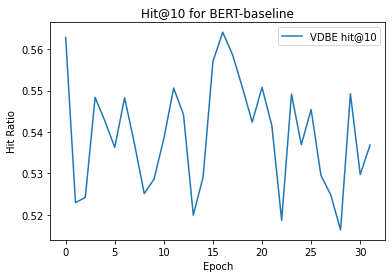

In [38]:
plt.plot(res, label='VDBE hit@10')
# plt.plot(baseline100, label='baseline hit@10')
# plt.plot(pd.Series(res).rolling(30).mean(), label='VDBE hit@10 ma 30')
# plt.plot(pd.Series(baseline100).rolling(30).mean(), label='Baseline hit@10 ma 30')
plt.xlabel('Epoch')
plt.ylabel('Hit Ratio')
plt.title('Hit@10 for BERT-baseline')
# plt.ylim([0.4, 0.6])
plt.legend()

In [23]:
with open('../Experiment/vdbe_100_max_target.pkl', 'wb') as file_pi:
  pickle.dump(res, file_pi, pickle.HIGHEST_PROTOCOL)

In [39]:
dqn.c_hist[-1]/sum(dqn.rec_list)

0.5406706451835664

In [17]:
'''
請不要關掉這ㄍ分頁 乾蝦哈咪搭
'''

'\n請不要關掉這ㄍ分頁 乾蝦哈咪搭\n'

In [24]:
with open('../Models/vdbe_100_target.pkl', 'wb') as file_pi:
  pickle.dump(dqn, file_pi, pickle.HIGHEST_PROTOCOL)

## Test for correct memory settings

In [194]:
%%time

'''
CURRENT_RUNNING: correct q memory & reward * total score
'''

exp_replay2 = ReplayBuffer(max_memory=MAX_MEMORY)
epsilon2 = VDBE(0.5, 0.01)
dqn2 = DQN(exp_replay2, epsilon2, 5, range(2), BATCH_SIZE, LR, SWITCH_PARAM_THRESHOLD)
%lprun -f dqn2.train  dqn2.train()

Epoch 0 started.   Time: 15:36:33


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0/2 | Loss 84.24398557795212 | Epoch Hit Rate 0.6416040100250626 |               Cumulative Hit Rate 0.6416040100250626 | Explore 187 | Exploit 212 |               Score 395
Epoch 1 started.   Time: 15:37:14


  0%|          | 0/5 [00:00<?, ?it/s]

Timer unit: 1e-09 s

Total time: 51.9529 s
File: <ipython-input-147-2ee99dcd434c>
Function: train at line 100

Line #      Hits         Time  Per Hit   % Time  Line Contents
   100                                             def train(self):
   101         1   14571425.0 14571425.0      0.0      self.eval_net.to(DEVICE)
   102         1     475983.0 475983.0      0.0      self.target_net.to(DEVICE)
   103         1        832.0    832.0      0.0      self.c_win_cnt = 0
   104         1      38920.0  38920.0      0.0      self.eval_net.train(True)
   105         1       3496.0   3496.0      0.0      self.epsilon.clear()
   106         1        398.0    398.0      0.0      self.explore = 0
   107         1        245.0    245.0      0.0      self.exploit = 0
   108                                           
   109         2       1204.0    602.0      0.0      for e in self.epochs:
   110         2        624.0    312.0      0.0        self.rec_cnt = 0
   111         2        430.0    215

Epoch: 1/2 | Loss 15.964139020594303 | Epoch Hit Rate 0.4367816091954023 |               Cumulative Hit Rate 0.6049382716049383 | Explore 228 | Exploit 258 |               Score 57
CPU times: user 1min 7s, sys: 308 ms, total: 1min 8s
Wall time: 52 s


In [195]:
%lprun -f exp_replay2.get_batch exp_replay2.get_batch(dqn2.eval_net, dqn2.target_net, batch_size=2)

Timer unit: 1e-09 s

Total time: 0.329238 s
File: <ipython-input-191-cfe761152fdd>
Function: get_batch at line 26

Line #      Hits         Time  Per Hit   % Time  Line Contents
    26                                             def get_batch(self, eval_net, target_net, batch_size=10):
    27                                               # How many experiences do we have?
    28         1        990.0    990.0      0.0      len_memory = len(self.memory)
    29                                           
    30                                               # Calculate the number of actions that can possibly be taken in the game.
    31                                               # Actions: 0 = not recommend, 1 = recommend
    32         1        329.0    329.0      0.0      num_actions = self.model_output_shape
    33                                           
    34                                               # Dimensions of our observed states, ie, the input to our model.
    35   

In [196]:
%lprun -f get_input_tensor get_input_tensor(CONTEXT_REPS.iloc[0], CONTEXT_REPS.iloc[0].name[1], with_tensor=True)

Timer unit: 1e-09 s

Total time: 0.0283332 s
File: <ipython-input-6-0d98a1c59d51>
Function: get_input_tensor at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def get_input_tensor(input_state, current_stream, with_tensor=False):
    10                                             # Get item feats
    11                                             # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
    12         1       2027.0   2027.0      0.0    item_list = STREAM_ITEM_DICT[current_stream]
    13         1    2111140.0 2111140.0      7.5    item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})
    14                                           
    15                                             # Fill in other context
    16         1   10931339.0 10931339.0     38.6    stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
    17                                 

## Profiling

In [193]:
%load_ext line_profiler
# %reload_ext line_profiler

In [107]:
%%time
exp_replay2 = ReplayBuffer(max_memory=MAX_MEMORY)
epsilon2 = VDBE(0.5, 0.01)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 10.3 µs


In [108]:
%%time
dqn2 = DQN(exp_replay2, epsilon2, 5, range(2), BATCH_SIZE, LR, SWITCH_PARAM_THRESHOLD)

CPU times: user 8.22 s, sys: 172 ms, total: 8.4 s
Wall time: 8.39 s


### Start Chasing

In [109]:
%lprun -f dqn2.train dqn2.train()

Epoch 0 started.   Time: 20:42:38


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0/2 | Loss 29.661170213483274 | Epoch Hit Rate 0.5357142857142857 |               Cumulative Hit Rate 0.5357142857142857 | Explore 35 | Exploit 49 | Score 73
Epoch 1 started.   Time: 20:42:52


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/2 | Loss 21.957408252041205 | Epoch Hit Rate 0.5808383233532934 |               Cumulative Hit Rate 0.5657370517928287 | Explore 126 | Exploit 125 | Score 160


Timer unit: 1e-09 s

Total time: 43.5841 s
File: <ipython-input-106-35d26399f5ef>
Function: train at line 102

Line #      Hits         Time  Per Hit   % Time  Line Contents
   102                                             def train(self):
   103         1   14851547.0 14851547.0      0.0      self.eval_net.to(DEVICE)
   104         1     470070.0 470070.0      0.0      self.target_net.to(DEVICE)
   105         1        630.0    630.0      0.0      self.c_win_cnt = 0
   106         1      41511.0  41511.0      0.0      self.eval_net.train(True)
   107         1       3745.0   3745.0      0.0      self.epsilon.clear()
   108         1        403.0    403.0      0.0      self.explore = 0
   109         1        293.0    293.0      0.0      self.exploit = 0
   110                                           
   111         2       1402.0    701.0      0.0      for e in self.epochs:
   112         2        774.0    387.0      0.0        self.rec_cnt = 0
   113         2        580.0    290

### old profiling

In [118]:
%lprun -f exp_replay2.get_batch exp_replay2.get_batch(dqn2.eval_net, dqn2.target_net, batch_size=2)

Timer unit: 1e-09 s

Total time: 0.0906188 s
File: <ipython-input-103-790fe20007f1>
Function: get_batch at line 26

Line #      Hits         Time  Per Hit   % Time  Line Contents
    26                                             def get_batch(self, eval_net, target_net, batch_size=10):
    27                                               # How many experiences do we have?
    28         1       1053.0   1053.0      0.0      len_memory = len(self.memory)
    29                                           
    30                                               # Calculate the number of actions that can possibly be taken in the game.
    31                                               # Actions: 0 = not recommend, 1 = recommend
    32         1        399.0    399.0      0.0      num_actions = self.model_output_shape
    33                                           
    34                                               # Dimensions of our observed states, ie, the input to our model.
    35  

In [119]:
%lprun -f get_input_tensor get_input_tensor(CONTEXT_REPS.iloc[0], CONTEXT_REPS.iloc[0].name[1], with_tensor=True)

Timer unit: 1e-09 s

Total time: 0.0201811 s
File: <ipython-input-102-0d98a1c59d51>
Function: get_input_tensor at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def get_input_tensor(input_state, current_stream, with_tensor=False):
    10                                             # Get item feats
    11                                             # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
    12         1       2116.0   2116.0      0.0    item_list = STREAM_ITEM_DICT[current_stream]
    13         1    2208028.0 2208028.0     10.9    item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})
    14                                           
    15                                             # Fill in other context
    16         1   16447950.0 16447950.0     81.5    stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
    17                               

### Cleansing
Original Version:
```python
'''
METHOD FOR BOTH EXP_REPLAY & DQN

Convert state format to model input format
'''
def get_input(input_state, current_stream):
  # Get item feats
  # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list]

  # Create new df
  stream_item_feat = pd.DataFrame(columns=INPUT_DF_COL)

  # Fill in other context
  stream_item_feat = stream_item_feat.append([input_state]*len(item_list),ignore_index=True)
  
  # stream_item_feat
  stream_item_feat[LB_ITEMS] = item_feat.reset_index()
  
  return stream_item_feat.astype('float32')
```

In [25]:
%load_ext heat

In [31]:
'''
METHOD FOR BOTH EXP_REPLAY & DQN
Convert state format to model input format

LB_ITEMS = ['item_id'] + [f'i{x}' for x in range(160)]
INPUT_DF_COL__USR = CONTEXT_REPS.columns.to_list()
INPUT_DF_COL = INPUT_DF_COL__USR + LB_ITEMS
'''
input_state = CONTEXT_REPS.iloc[0]
current_stream = CONTEXT_REPS.iloc[0].name[1]
def new_get_input(input_state, current_stream):
  # Get item feats
  # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list]

  for idx in input_state.index: item_feat[idx] = input_state[idx]
  item_feat_ri = item_feat.reset_index().rename(columns={'index':'item_id'})
  
  return item_feat_ri

In [23]:
%lprun -f new_get_input new_get_input(CONTEXT_REPS.iloc[0], CONTEXT_REPS.iloc[0].name[1])

Timer unit: 1e-09 s

Total time: 0.107122 s
File: <ipython-input-22-07c49d6a115a>
Function: new_get_input at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                           def new_get_input(input_state, current_stream):
    12                                             # Get item feats
    13                                             # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
    14         1       2309.0   2309.0      0.0    item_list = STREAM_ITEM_DICT[current_stream]
    15         1     396509.0 396509.0      0.4    item_feat = BERT_BY_IDX_DF.loc[item_list]
    16                                           
    17       219  105267435.0 480673.2     98.3    for idx in input_state.index: item_feat[idx] = input_state[idx]
    18         1    1455838.0 1455838.0      1.4    item_feat_ri = item_feat.reset_index().rename(columns={'index':'item_id'})
    19                                             
    20         1        133.0    1

In [39]:
def get_input_v2(input_state, current_stream):
  # Get item feats
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})

  # Fill in other context
  stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
  
  # Merge with items
  stream_item_feat = stream_item_feat.merge(item_feat, left_index=True, right_index=True).astype('float32')
  return stream_item_feat

In [85]:
%lprun -f get_input_v2 get_input_v2(CONTEXT_REPS.iloc[0], CONTEXT_REPS.iloc[0].name[1])

Timer unit: 1e-09 s

Total time: 0.0176343 s
File: <ipython-input-84-4d017c41242b>
Function: get_input_v2 at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def get_input_v2(input_state, current_stream):
    10                                             # Get item feats
    11                                             # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
    12         1       8785.0   8785.0      0.0    item_list = STREAM_ITEM_DICT[current_stream]
    13         1    5560119.0 5560119.0     31.5    item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})
    14                                           
    15                                             # Fill in other context
    16         1   10882756.0 10882756.0     61.7    stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
    17                                             
    18       

### Chasing 2

In [88]:
%%time
baseline_model3 = Baseline()

CPU times: user 115 µs, sys: 2.91 ms, total: 3.02 ms
Wall time: 2.34 ms


In [89]:
%%time
exp_replay3 = ReplayBuffer(max_memory=MAX_MEMORY)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [90]:
%%time
dqn3 = DQN(baseline_model3, exp_replay3, 5, EPOCH, BATCH_SIZE, LR)

CPU times: user 8.32 s, sys: 177 ms, total: 8.5 s
Wall time: 8.49 s


### Start Chasing

In [91]:
%lprun -f dqn3.train dqn3.train()

Epoch 0 started.   Time: 15:23:38


  0%|          | 0/5 [00:00<?, ?it/s]

Timer unit: 1e-09 s

Total time: 3.32292 s
File: <ipython-input-87-1e430f3ba6d5>
Function: train at line 93

Line #      Hits         Time  Per Hit   % Time  Line Contents
    93                                             def train(self):
    94         1   16194974.0 16194974.0      0.5      self.model.to(DEVICE)
    95         1        950.0    950.0      0.0      self.c_win_cnt = 0
    96         1      40919.0  40919.0      0.0      self.model.train(True)
    97                                           
    98         1        738.0    738.0      0.0      for e in self.epochs:
    99         1        361.0    361.0      0.0        self.rec_cnt = 0
   100         1        335.0    335.0      0.0        self.win_cnt = 0
   101         1        395.0    395.0      0.0        self.loss = 0.
   102         1       1624.0   1624.0      0.0        self.epsilon = 4 / ((e + 1) ** (1 / 2))
   103                                           
   104         1      99669.0  99669.0      0.0    

Epoch: 0/100 | Loss 2.4590116441249847 | Epoch Hit Rate 0.775 | Cumulative Hit Rate 0.775 |              Time 15:23:41


In [92]:
%lprun -f exp_replay3.get_batch exp_replay3.get_batch(baseline_model3, batch_size=2)

Timer unit: 1e-09 s

Total time: 0.0848023 s
File: <ipython-input-86-f9f91d8b7747>
Function: get_batch at line 26

Line #      Hits         Time  Per Hit   % Time  Line Contents
    26                                             def get_batch(self, model, batch_size=10):
    27                                               # How many experiences do we have?
    28         1       1013.0   1013.0      0.0      len_memory = len(self.memory)
    29                                           
    30                                               # Calculate the number of actions that can possibly be taken in the game.
    31                                               # Actions: 0 = not recommend, 1 = recommend
    32         1        741.0    741.0      0.0      num_actions = self.model_output_shape
    33                                           
    34                                               # Dimensions of our observed states, ie, the input to our model.
    35                  

Per hit
* exp/get_input:
  * v1: `49609136.0`
  * v2: `12412833.5`
* train/get_batch:
  * v1: `216278453.8`
  * v2: `78445226.8`

In [66]:
predicts = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
if len(predicts) > 10:
  ind = np.argpartition(predicts, -10)[-10:]
  q_val = predicts[ind].sum()
else:
  q_val = predicts.sum()
q_val

tensor(85)

In [67]:
predicts[ind]

tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13])